In [ ]:
# !pip install igraph
# !pip install cairocffi

NOTEARS implementation description

Method for finding DAG structure learnign for linear models, by solving the optimization problem via a poximal quasi newton method (C.F algorithm 1 in the NOTEARS paper)

In [ ]:
import numpy as np
import scipy.linalg as slin
import scipy.optimize as sopt
from scipy.special import expit as sigmoid


def notears_linear(X, lambda1, loss_type, max_iter=100, h_tol=1e-8, rho_max=1e+16, w_threshold=0.3):
    """Solve min_W L(W; X) + lambda1 ‖W‖_1 s.t. h(W) = 0 using augmented Lagrangian.

    Args:
        X (np.ndarray): [n, d] sample matrix
        lambda1 (float): l1 penalty parameter
        loss_type (str): l2, logistic, poisson
        max_iter (int): max num of dual ascent steps
        h_tol (float): exit if |h(w_est)| <= htol
        rho_max (float): exit if rho >= rho_max
        w_threshold (float): drop edge if |weight| < threshold

    Returns:
        W_est (np.ndarray): [d, d] estimated DAG
    """
    def _loss(W):
        """Evaluate value and gradient of loss."""
        M = X @ W
        if loss_type == 'l2':
            R = X - M
            loss = 0.5 / X.shape[0] * (R ** 2).sum()
            G_loss = - 1.0 / X.shape[0] * X.T @ R
        elif loss_type == 'logistic':
            loss = 1.0 / X.shape[0] * (np.logaddexp(0, M) - X * M).sum()
            G_loss = 1.0 / X.shape[0] * X.T @ (sigmoid(M) - X)
        elif loss_type == 'poisson':
            S = np.exp(M)
            loss = 1.0 / X.shape[0] * (S - X * M).sum()
            G_loss = 1.0 / X.shape[0] * X.T @ (S - X)
        else:
            raise ValueError('unknown loss type')
        return loss, G_loss

    def _h(W):
        """Evaluate value and gradient of acyclicity constraint."""
        E = slin.expm(W * W)  # (Zheng et al. 2018)
        h = np.trace(E) - d
        #     # A different formulation, slightly faster at the cost of numerical stability
        #     M = np.eye(d) + W * W / d  # (Yu et al. 2019)
        #     E = np.linalg.matrix_power(M, d - 1)
        #     h = (E.T * M).sum() - d
        G_h = E.T * W * 2
        return h, G_h

    def _adj(w):
        """Convert doubled variables ([2 d^2] array) back to original variables ([d, d] matrix)."""
        return (w[:d * d] - w[d * d:]).reshape([d, d])

    def _func(w):
        """Evaluate value and gradient of augmented Lagrangian for doubled variables ([2 d^2] array)."""
        W = _adj(w)
        loss, G_loss = _loss(W)
        h, G_h = _h(W)
        obj = loss + 0.5 * rho * h * h + alpha * h + lambda1 * w.sum()
        G_smooth = G_loss + (rho * h + alpha) * G_h
        g_obj = np.concatenate((G_smooth + lambda1, - G_smooth + lambda1), axis=None)
        return obj, g_obj

    n, d = X.shape
    w_est, rho, alpha, h = np.zeros(2 * d * d), 1.0, 0.0, np.inf  # double w_est into (w_pos, w_neg)
    bnds = [(0, 0) if i == j else (0, None) for _ in range(2) for i in range(d) for j in range(d)]
    if loss_type == 'l2':
        X = X - np.mean(X, axis=0, keepdims=True)
    for _ in range(max_iter):
        w_new, h_new = None, None
        while rho < rho_max:
            sol = sopt.minimize(_func, w_est, method='L-BFGS-B', jac=True, bounds=bnds)
            w_new = sol.x
            h_new, _ = _h(_adj(w_new))
            if h_new > 0.25 * h:
                rho *= 10
            else:
                break
        w_est, h = w_new, h_new
        alpha += rho * h
        if h <= h_tol or rho >= rho_max:
            break
    W_est = _adj(w_est)
    W_est[np.abs(W_est) < w_threshold] = 0
    return W_est


DAG utils. Functions for evaluating if a weighted adjacency matrix describes a DAG, for generating DAGs according to Erdos-Renyi, Barbarasi or bipartite schemes,

In [ ]:
import numpy as np
from scipy.special import expit as sigmoid
import igraph as ig
import random


def set_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)

def is_dag(W): # verifies if W descries a DAG (weighted adjacency matrix)
    G = ig.Graph.Weighted_Adjacency(W.tolist())
    return G.is_dag()


####################################### Ground truth graph and params generation ######################


def simulate_dag(d, s0, graph_type):
    """Simulate random DAG with some expected number of edges.

    Args:
        d (int): num of nodes
        s0 (int): expected num of edges
        graph_type (str): ER, SF, BP

    Returns:
        B (np.ndarray): [d, d] binary adj matrix of DAG
    """
    def _random_permutation(M): # Randomly permutes matrix M
        P = np.random.permutation(np.eye(M.shape[0]))
        return P.T @ M @ P

    def _random_acyclic_orientation(B_und): # Randomly permutes the adjacency matrix (induces an ordering on the vertices) and the lower triangulation enforces a topological ordering
        return np.tril(_random_permutation(B_und), k=-1)

    def _graph_to_adjmat(G): # converts a graph from the igraph library to its adjacency matrix (numpy array)
        return np.array(G.get_adjacency().data)

    if graph_type == 'ER':
        # Erdos-Renyi graph: the n,M model where we enforce M edges to be present in the graph in expectation
        G_und = ig.Graph.Erdos_Renyi(n=d, m=s0)
        B_und = _graph_to_adjmat(G_und)
        B = _random_acyclic_orientation(B_und) # Enforcing acyclicity
    elif graph_type == 'SF': #
        # Scale-free, Barabasi-Albert the more connections a node has, the more likely it is to have more edges
        G = ig.Graph.Barabasi(n=d, m=int(round(s0 / d)), directed=True)
        B = _graph_to_adjmat(G)
    elif graph_type == 'BP':
        # Bipartite, Sec 4.1 of (Gu, Fu, Zhou, 2018)
        top = int(0.2 * d)
        G = ig.Graph.Random_Bipartite(top, d - top, m=s0, directed=True, neimode=ig.OUT)
        B = _graph_to_adjmat(G)
    else:
        raise ValueError('unknown graph type')
    B_perm = _random_permutation(B)
    assert ig.Graph.Adjacency(B_perm.tolist()).is_dag()
    return B_perm


def simulate_parameter(B, w_ranges=((-2.0, -0.5), (0.5, 2.0))):
    """Simulate SEM parameters for a DAG.

    Args:
        B (np.ndarray): [d, d] binary adj matrix of DAG
        w_ranges (tuple): disjoint weight ranges

    Returns:
        W (np.ndarray): [d, d] weighted adj matrix of DAG
    """
    W = np.zeros(B.shape)
    S = np.random.randint(len(w_ranges), size=B.shape)  # which range
    for i, (low, high) in enumerate(w_ranges):
        U = np.random.uniform(low=low, high=high, size=B.shape)
        W += B * (S == i) * U
    return W




Simulate samples from either a linear on non linear structural equation model

In [ ]:
def simulate_linear_sem(W, n, sem_type, noise_scale=None):
    """Simulate samples from linear SEM with specified type of noise.

    For uniform, noise z ~ uniform(-a, a), where a = noise_scale.

    Args:
        W (np.ndarray): [d, d] weighted adj matrix of DAG
        n (int): num of samples, n=inf mimics population risk
        sem_type (str): gauss, exp, gumbel, uniform, logistic, poisson
        noise_scale (np.ndarray): scale parameter of additive noise, default all ones

    Returns:
        X (np.ndarray): [n, d] sample matrix, [d, d] if n=inf
    """
    def _simulate_single_equation(X, w, scale):
        """X: [n, num of parents], w: [num of parents], x: [n]"""
        if sem_type == 'gauss':
            z = np.random.normal(scale=scale, size=n)
            x = X @ w + z
        elif sem_type == 'exp':
            z = np.random.exponential(scale=scale, size=n)
            x = X @ w + z
        elif sem_type == 'gumbel':
            z = np.random.gumbel(scale=scale, size=n)
            x = X @ w + z
        elif sem_type == 'uniform':
            z = np.random.uniform(low=-scale, high=scale, size=n)
            x = X @ w + z
        elif sem_type == 'logistic':
            x = np.random.binomial(1, sigmoid(X @ w)) * 1.0
        elif sem_type == 'poisson':
            x = np.random.poisson(np.exp(X @ w)) * 1.0
        else:
            raise ValueError('unknown sem type')
        return x

    d = W.shape[0]
    if noise_scale is None:
        scale_vec = np.ones(d)
    elif np.isscalar(noise_scale):
        scale_vec = noise_scale * np.ones(d)
    else:
        if len(noise_scale) != d:
            raise ValueError('noise scale must be a scalar or has length d')
        scale_vec = noise_scale
    if not is_dag(W):
        raise ValueError('W must be a DAG')
    if np.isinf(n):  # population risk for linear gauss SEM
        if sem_type == 'gauss':
            # make 1/d X'X = true cov
            X = np.sqrt(d) * np.diag(scale_vec) @ np.linalg.inv(np.eye(d) - W)
            return X
        else:
            raise ValueError('population risk not available')
    # empirical risk
    G = ig.Graph.Weighted_Adjacency(W.tolist())
    ordered_vertices = G.topological_sorting()
    assert len(ordered_vertices) == d
    X = np.zeros([n, d])
    for j in ordered_vertices:
        parents = G.neighbors(j, mode=ig.IN)
        X[:, j] = _simulate_single_equation(X[:, parents], W[parents, j], scale_vec[j])
    return X


def simulate_nonlinear_sem(B, n, sem_type, noise_scale=None):
    """Simulate samples from nonlinear SEM.

    Args:
        B (np.ndarray): [d, d] binary adj matrix of DAG
        n (int): num of samples
        sem_type (str): mlp, mim, gp, gp-add
        noise_scale (np.ndarray): scale parameter of additive noise, default all ones

    Returns:
        X (np.ndarray): [n, d] sample matrix
    """
    def _simulate_single_equation(X, scale):
        """X: [n, num of parents], x: [n]"""
        z = np.random.normal(scale=scale, size=n)
        pa_size = X.shape[1]
        if pa_size == 0:
            return z
        if sem_type == 'mlp':
            hidden = 100
            W1 = np.random.uniform(low=0.5, high=2.0, size=[pa_size, hidden])
            W1[np.random.rand(*W1.shape) < 0.5] *= -1
            W2 = np.random.uniform(low=0.5, high=2.0, size=hidden)
            W2[np.random.rand(hidden) < 0.5] *= -1
            x = sigmoid(X @ W1) @ W2 + z
        elif sem_type == 'mim':
            w1 = np.random.uniform(low=0.5, high=2.0, size=pa_size)
            w1[np.random.rand(pa_size) < 0.5] *= -1
            w2 = np.random.uniform(low=0.5, high=2.0, size=pa_size)
            w2[np.random.rand(pa_size) < 0.5] *= -1
            w3 = np.random.uniform(low=0.5, high=2.0, size=pa_size)
            w3[np.random.rand(pa_size) < 0.5] *= -1
            x = np.tanh(X @ w1) + np.cos(X @ w2) + np.sin(X @ w3) + z
        elif sem_type == 'gp':
            from sklearn.gaussian_process import GaussianProcessRegressor
            gp = GaussianProcessRegressor()
            x = gp.sample_y(X, random_state=None).flatten() + z
        elif sem_type == 'gp-add':
            from sklearn.gaussian_process import GaussianProcessRegressor
            gp = GaussianProcessRegressor()
            x = sum([gp.sample_y(X[:, i, None], random_state=None).flatten()
                     for i in range(X.shape[1])]) + z
        else:
            raise ValueError('unknown sem type')
        return x

    d = B.shape[0]
    scale_vec = noise_scale if noise_scale else np.ones(d)
    X = np.zeros([n, d])
    G = ig.Graph.Adjacency(B.tolist())
    ordered_vertices = G.topological_sorting()
    assert len(ordered_vertices) == d
    for j in ordered_vertices:
        parents = G.neighbors(j, mode=ig.IN)
        X[:, j] = _simulate_single_equation(X[:, parents], scale_vec[j])
    return X



Evaluation metric between the estimated graph and the ground truth graph

In [ ]:
def count_accuracy(B_true, B_est):
    """Compute various accuracy metrics for B_est.

    true positive = predicted association exists in condition in correct direction
    reverse = predicted association exists in condition in opposite direction
    false positive = predicted association does not exist in condition

    Args:
        B_true (np.ndarray): [d, d] ground truth graph, {0, 1}
        B_est (np.ndarray): [d, d] estimate, {0, 1, -1}, -1 is undirected edge in CPDAG

    Returns:
        fdr: (reverse + false positive) / prediction positive
        tpr: (true positive) / condition positive
        fpr: (reverse + false positive) / condition negative
        shd: undirected extra + undirected missing + reverse
        nnz: prediction positive
    """
    if (B_est == -1).any():  # cpdag
        if not ((B_est == 0) | (B_est == 1) | (B_est == -1)).all():
            raise ValueError('B_est should take value in {0,1,-1}')
        if ((B_est == -1) & (B_est.T == -1)).any():
            raise ValueError('undirected edge should only appear once')
    else:  # dag
        if not ((B_est == 0) | (B_est == 1)).all():
            raise ValueError('B_est should take value in {0,1}')
        if not is_dag(B_est):
            raise ValueError('B_est should be a DAG')
    d = B_true.shape[0]
    # linear index of nonzeros
    pred_und = np.flatnonzero(B_est == -1)
    pred = np.flatnonzero(B_est == 1)
    cond = np.flatnonzero(B_true)
    cond_reversed = np.flatnonzero(B_true.T)
    cond_skeleton = np.concatenate([cond, cond_reversed])
    # true pos
    true_pos = np.intersect1d(pred, cond, assume_unique=True)
    # treat undirected edge favorably
    true_pos_und = np.intersect1d(pred_und, cond_skeleton, assume_unique=True)
    true_pos = np.concatenate([true_pos, true_pos_und])
    # false pos
    false_pos = np.setdiff1d(pred, cond_skeleton, assume_unique=True)
    false_pos_und = np.setdiff1d(pred_und, cond_skeleton, assume_unique=True)
    false_pos = np.concatenate([false_pos, false_pos_und])
    # reverse
    extra = np.setdiff1d(pred, cond, assume_unique=True)
    reverse = np.intersect1d(extra, cond_reversed, assume_unique=True)
    # compute ratio
    pred_size = len(pred) + len(pred_und)
    cond_neg_size = 0.5 * d * (d - 1) - len(cond)
    fdr = float(len(reverse) + len(false_pos)) / max(pred_size, 1)
    tpr = float(len(true_pos)) / max(len(cond), 1)
    fpr = float(len(reverse) + len(false_pos)) / max(cond_neg_size, 1)
    # structural hamming distance
    pred_lower = np.flatnonzero(np.tril(B_est + B_est.T))
    cond_lower = np.flatnonzero(np.tril(B_true + B_true.T))
    extra_lower = np.setdiff1d(pred_lower, cond_lower, assume_unique=True)
    missing_lower = np.setdiff1d(cond_lower, pred_lower, assume_unique=True)
    shd = len(extra_lower) + len(missing_lower) + len(reverse)
    return {'fdr': fdr, 'tpr': tpr, 'fpr': fpr, 'structural_hamming_du': shd, 'nnz': pred_size}

In [ ]:
# n, d, s0, graph_type, sem_type = 100, 20, 20, 'ER', 'gauss'
# B_true = simulate_dag(d, s0, graph_type)
# W_true = simulate_parameter(B_true)
# np.savetxt('W_true.csv', W_true, delimiter=',')

# X = simulate_linear_sem(W_true, n, sem_type)
# np.savetxt('X.csv', X, delimiter=',')

# W_est = notears_linear(X, lambda1=0.1, loss_type='l2')
# assert is_dag(W_est)
# np.savetxt('W_est.csv', W_est, delimiter=',')
# acc = count_accuracy(B_true, W_est != 0)
# print(acc)

In [ ]:
# G = ig.Graph.Weighted_Adjacency(W_est.tolist())
# ig.plot(G, bbox=(0, 0, 250, 250))

# Vincent's playground

In [ ]:
def intersection_of_dags(W1, W2):
    """
    Compute the intersection of two DAGs represented by weighted adjacency matrices.

    Parameters:
        W1 (np.ndarray): [d, d] weighted adjacency matrix of the first DAG.
        W2 (np.ndarray): [d, d] weighted adjacency matrix of the second DAG.

    Returns:
        np.ndarray: [d, d] weighted adjacency matrix of the intersection of W1 and W2.
    """
    # Identify common edges (non-zero in both matrices)
    common_edges_mask = (W1 > 0) & (W2 > 0)

    # Compute the intersection: take minimum weights of common edges
    intersection = np.zeros_like(W1)
    intersection[common_edges_mask] = 1

    return intersection

In [ ]:
from sklearn.mixture import GaussianMixture

# Number of samples for each distribution
n1 = 1000
n2 = 1000

# d: number of nodes
# s0: number of edges
d, s0, graph_type, sem_type = 5, 3, 'ER', 'gauss'
# d, s0, graph_type, sem_type = 30, 10, 'ER', 'uniform'

cond = True

while cond:
  # Generate graph 1 and n1 samples from it
  B_true1 = simulate_dag(d, s0, graph_type)
  W_true1 = simulate_parameter(B_true1)
  np.savetxt('W_true1.csv', W_true1, delimiter=',')
  X1 = simulate_linear_sem(W_true1, n1, sem_type)
  # X1 = simulate_nonlinear_sem(B_true1, n1, 'gp-add')

  # Generate graph 2 and n2 samples from it
  B_true2 = simulate_dag(d, s0, graph_type)
  W_true2 = simulate_parameter(B_true2)
  np.savetxt('W_true1.csv', W_true2, delimiter=',')
  X2 = simulate_linear_sem(W_true2, n2, sem_type)
  # X2 = simulate_nonlinear_sem(B_true2, n2, 'gp-add')

  W_true_all = intersection_of_dags(W_true1, W_true2)

  if W_true_all.any():
    cond = False

# Merge the samples
X = np.concatenate([X1, X2])[np.random.shuffle(np.arange(n1+n2))][0]
# Train Gaussian Mixture Model to split back the dataset into two distributions
GMM = GaussianMixture(n_components=2, covariance_type="full", max_iter=1000)
GMM.fit(X)

# Split back the dataset into two
preds = GMM.predict(X)
X_est1 = X[preds == 0]
X_est2 = X[preds == 1]

# Learn two graphs
W_est1 = notears_linear(X_est1, lambda1=0.1, loss_type='l2', w_threshold=0.3)
W_est2 = notears_linear(X_est2, lambda1=0.1, loss_type='l2', w_threshold=0.3)

W_est_intersect = intersection_of_dags(W_est1, W_est2)
W_est_all = notears_linear(X, lambda1=0.1, loss_type='l2', w_threshold=0.3)

In [ ]:
correct1 = 0
for x in X_est1:
  if x in X1:
    correct1 += 1
for x in X_est2:
  if x in X2:
    correct1 += 1

correct2 = 0
for x in X_est2:
  if x in X1:
    correct2 += 1
for x in X_est1:
  if x in X2:
    correct2 += 1
print(f"Correct classes : {max(correct1, correct2)/(n1+n2)}")

Correct classes : 0.845


DAG A


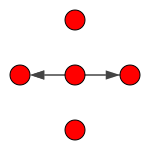

In [ ]:
print("DAG A")
g1 = ig.Graph.Weighted_Adjacency(W_true1.tolist())
ig.plot(ig.Graph.Weighted_Adjacency(W_true1.tolist()), bbox=(0, 0, 150, 150), layout=g1.layout_star())

DAG B


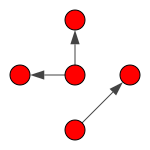

In [ ]:
print("DAG B")
g2 = ig.Graph.Weighted_Adjacency(W_true2.tolist())
ig.plot(ig.Graph.Weighted_Adjacency(W_true2.tolist()), bbox=(0, 0, 150, 150), layout=g2.layout_star())

Learned DAG 1


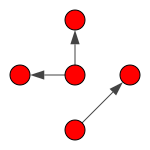

In [ ]:
print("Learned DAG 1")
g1 = ig.Graph.Weighted_Adjacency(W_est1.tolist())
ig.plot(g1, bbox=(0, 0, 150, 150), layout=g1.layout_star())

Learned DAG 2


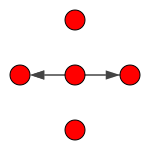

In [ ]:
print("Learned DAG 2")
g2 = ig.Graph.Weighted_Adjacency(W_est2.tolist())
ig.plot(g2, bbox=(0, 0, 150, 150), layout=g2.layout_star())

True Intersection


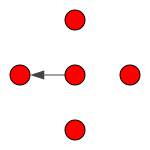

In [ ]:
print("True Intersection")
g2 = ig.Graph.Weighted_Adjacency(W_true_all.tolist())
ig.plot(g2, bbox=(0, 0, 150, 150), layout=g2.layout_star())

Intersection of Learned DAGs


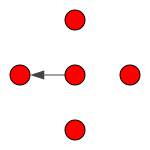

In [ ]:
print("Intersection of Learned DAGs")
g2 = ig.Graph.Weighted_Adjacency(W_est_intersect.tolist())
ig.plot(g2, bbox=(0, 0, 150, 150), layout=g2.layout_star())

Learned DAG NOTEARS


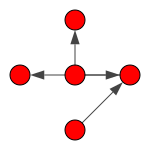

In [ ]:
print("Learned DAG NOTEARS")
g2 = ig.Graph.Weighted_Adjacency(W_est_all.tolist())
ig.plot(g2, bbox=(0, 0, 150, 150), layout=g2.layout_star())

# Vincent's experiments

In [ ]:
from sklearn.mixture import GaussianMixture
from tqdm import tqdm

N_ITERS = 10

# Number of samples for each distribution
n1 = 250
n2 = 250

# d: number of nodes
# s0: number of edges
d, s0, graph_type, sem_type = 30, 15, 'ER', 'gauss'
# d, s0, graph_type, sem_type = 30, 10, 'ER', 'uniform'

results = []

for _ in tqdm(range(N_ITERS)):
  # We want a graph where the intersection of the edges is non-empty
  cond = True
  while cond:
    # Generate graph 1 and n1 samples from it
    B_true1 = simulate_dag(d, s0, graph_type)
    W_true1 = simulate_parameter(B_true1)
    np.savetxt('W_true1.csv', W_true1, delimiter=',')
    X1 = simulate_linear_sem(W_true1, n1, sem_type)
    # X1 = simulate_nonlinear_sem(B_true1, n1, 'gp-add')

    # Generate graph 2 and n2 samples from it
    B_true2 = simulate_dag(d, s0, graph_type)
    W_true2 = simulate_parameter(B_true2)
    np.savetxt('W_true1.csv', W_true2, delimiter=',')
    X2 = simulate_linear_sem(W_true2, n2, sem_type)
    # X2 = simulate_nonlinear_sem(B_true2, n2, 'gp-add')

    W_true_all = intersection_of_dags(W_true1, W_true2)

    if W_true_all.any():
      cond = False

  # Merge the samples
  X = np.concatenate([X1, X2])[np.random.shuffle(np.arange(n1+n2))][0]
  # Train Gaussian Mixture Model to split back the dataset into two distributions
  GMM = GaussianMixture(n_components=2, covariance_type="full", max_iter=1000)
  GMM.fit(X)

  # Split back the dataset into two
  preds = GMM.predict(X)
  X_est1 = X[preds == 0]
  X_est2 = X[preds == 1]

  # Learn two graphs
  W_est1 = notears_linear(X_est1, lambda1=0.1, loss_type='l2', w_threshold=0.3)
  W_est2 = notears_linear(X_est2, lambda1=0.1, loss_type='l2', w_threshold=0.3)

  W_est_intersect = intersection_of_dags(W_est1, W_est2)
  W_est_all = notears_linear(X, lambda1=0.1, loss_type='l2', w_threshold=0.3)

  # Get metric
  correct1 = 0
  for x in X_est1:
    if x in X1:
      correct1 += 1
  for x in X_est2:
    if x in X2:
      correct1 += 1

  correct2 = 0
  for x in X_est2:
    if x in X1:
      correct2 += 1
  for x in X_est1:
    if x in X2:
      correct2 += 1
  correct = max(correct1, correct2)/(n1+n2)

  notears_extra = np.sum(np.logical_and(W_est_all, np.logical_not(W_true_all)))
  notears_missing = np.sum(np.logical_and(W_true_all, np.logical_not(W_est_all)))
  gmm_extra = np.sum(np.logical_and(W_est_intersect, np.logical_not(W_true_all)))
  gmm_missing = np.sum(np.logical_and(W_true_all, np.logical_not(W_est_intersect)))

  results.append([correct, notears_extra, notears_missing, gmm_extra, gmm_missing])

results = np.array(results)

  0%|          | 0/10 [01:08<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
for i in range(5):
  print(results[:, i].mean())

0.9025000000000001
7.7
0.0
0.1
0.0
